In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft, ifft

import os
import wfdb # MIT-BIH files

ARRYTHMIA_PATH = "data/arrythmia_rates/"
NORMAL_PATH = "data/normal_rates/"


anomalies = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

normal = ['N'] 


**N** - NORMAL, Normal beat <br>
**L** - LBBB, Left bundle branch block beat <br>
**R** - RBBB, Right bundle branch block beat <br>
**a** - ABERR, Aberrated atrial premature beat <br>
**V** - PVC, Premature ventricular contraction <br>
**F** - FUSION, Fusion of ventricular and normal beat <br>
**J** - NPC, Nodal (junctional) premature beat <br>
**A** - APC, Atrial premature contraction <br>
**S** - SVPB, Premature or ectopic supraventricular beat <br>
**E** - VESC, Ventricular escape beat <br>
**j** - NESC, Nodal (junctional) escape beat <br>
**/** - PACE, Paced beat <br>
**f** - PFUS, Fusion of paced and normal beat <br>
**e** - AESC, Atrial escape beat <br>

In [49]:
for file in os.listdir(ARRYTHMIA_PATH)[:3]:
    print(file)
    if file.endswith("atr"):
        temp = wfdb.rdann(ARRYTHMIA_PATH + file.split(".")[0], "atr", sampto=300)
    if file.endswith("dat"):
        record = wfdb.rdrecord(ARRYTHMIA_PATH + file.split(".")[0], sampto=300)

100.atr
100.dat
100.hea


I only need **MLII (Modified Lead II)** signals, because they are the most essential here.

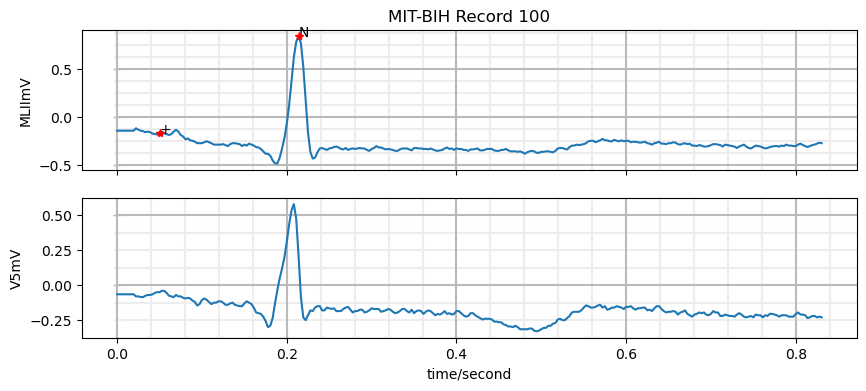

In [53]:
wfdb.plot_wfdb(record=record, annotation=temp, plot_sym=True,
                   time_units='seconds', title='MIT-BIH Record 100',
                   figsize=(10,4), ecg_grids='all')

In [81]:
record.p_signal[18]

array([-0.17, -0.05])

In [71]:
temp.sample

array([18, 77], dtype=int64)

In [240]:
def plot_signal(signal: np.array, annot_sample: int, annot_symbol: str, fs=360):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(signal.shape[0]) / fs, signal, c="springgreen")
    ax.plot(annot_sample / fs, signal[annot_sample], 'ro', alpha=0.5)
    ax.annotate(annot_symbol, [annot_sample / fs + 0.02, signal[annot_sample]], c="white")
    ax.set_ylabel("Signal Strength [mV]")
    ax.set_xlabel("Seconds [s]")

    ax.set_facecolor((0.1, 0.1, 0.1))

    plt.title("MLII Signal Part")
    plt.tight_layout()
    plt.grid()
    plt.show()

In [136]:
def load_full_ecg(path, id):
    record = wfdb.rdrecord(path + id)
    ann = wfdb.rdann(path + id, "atr")

    signal = record.p_signal[:, 0] # MLII
    ann_sample = ann.sample # annotation locations
    ann_symbol = ann.symbol # annotation symbols
    
    return signal, ann_sample, ann_symbol

In [250]:
seconds = 1.2 # window around annotation
labels = []
signals = []
symbols = []
for patient in set([file[:3] for file in os.listdir(ARRYTHMIA_PATH)]): # unique patient ids
    ecg_signal, ecg_annotation, annotation_symbol = load_full_ecg(ARRYTHMIA_PATH, patient)
    
    for smpl, symb in zip(ecg_annotation, annotation_symbol):
        if symb in anomalies: # looking only for abnormal annotations here
            temp_signal = ecg_signal[smpl-int(seconds*360):smpl+int(seconds*360)]
            
            signals.append(temp_signal)
            labels.append(1) # marking anomalied as 1
            symbols.append(symb)

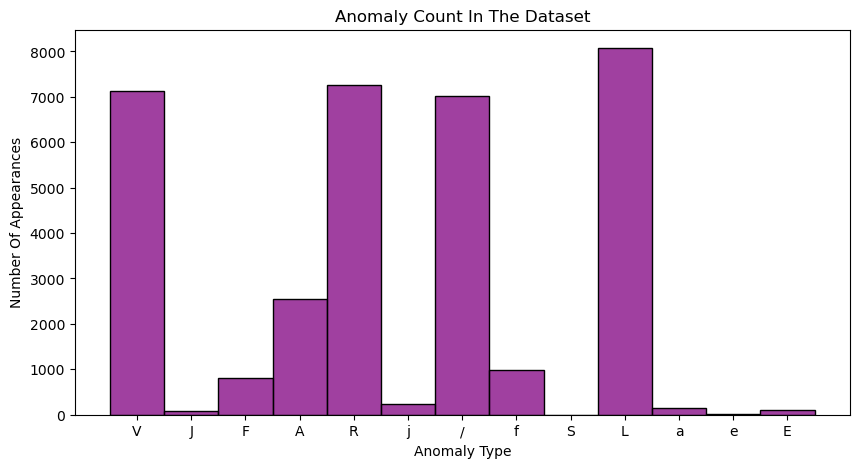

In [274]:
plt.figure(figsize=(10,5))
sns.histplot(np.array(symbols), color="purple")
plt.title("Anomaly Count In The Dataset")
plt.xlabel("Anomaly Type")
plt.ylabel("Number Of Appearances")
plt.show()

# Plotting random anomalies

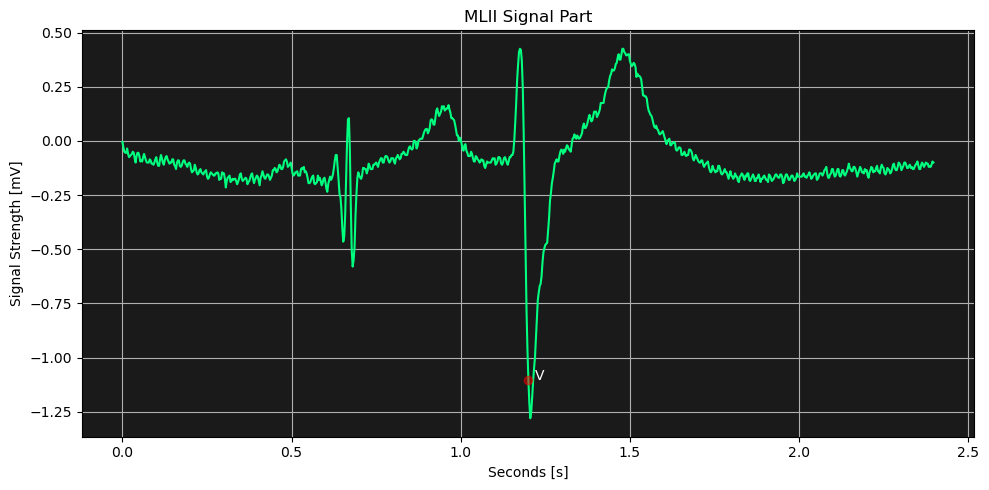

In [276]:
idx = symbols.index("V")
plot_signal(signals[idx], int(seconds*360), symbols[idx])

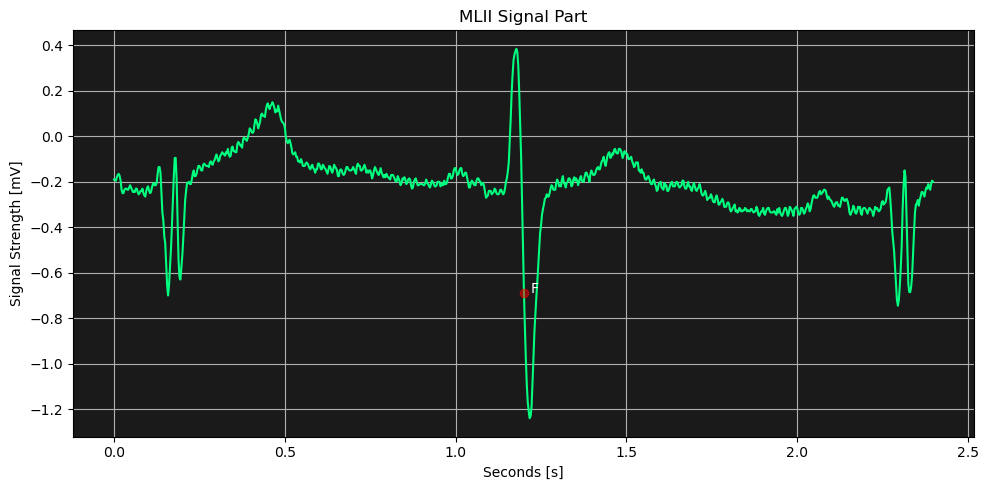

In [292]:
idx = symbols.index("F")
plot_signal(signals[idx], int(seconds*360), symbols[idx])

In [319]:
for file in os.listdir(NORMAL_PATH)[:3]:
    print(file)
    if file.endswith("atr"):
        temp = wfdb.rdann(NORMAL_PATH + file.split(".")[0], "atr")
    if file.endswith("dat"):
        record = wfdb.rdrecord(NORMAL_PATH + file.split(".")[0])

16265.atr
16265.dat
16265.hea


In [371]:
labels_tt = []
signals_tt = []
symbols_tt = []
for patient in set([file[:5] for file in os.listdir(NORMAL_PATH)]): # unique patient ids
    if not patient[0].isdigit():
        continue
    ecg_signal, ecg_annotation, annotation_symbol = load_full_ecg(NORMAL_PATH, patient)
    
    for smpl, symb in zip(ecg_annotation, annotation_symbol):
        temp_signal = ecg_signal[smpl-int(seconds*128):smpl+int(seconds*128)]
            
        signals_tt.append(temp_signal)
        labels_tt.append(0) # marking anomalied as 1
        symbols_tt.append(symb)

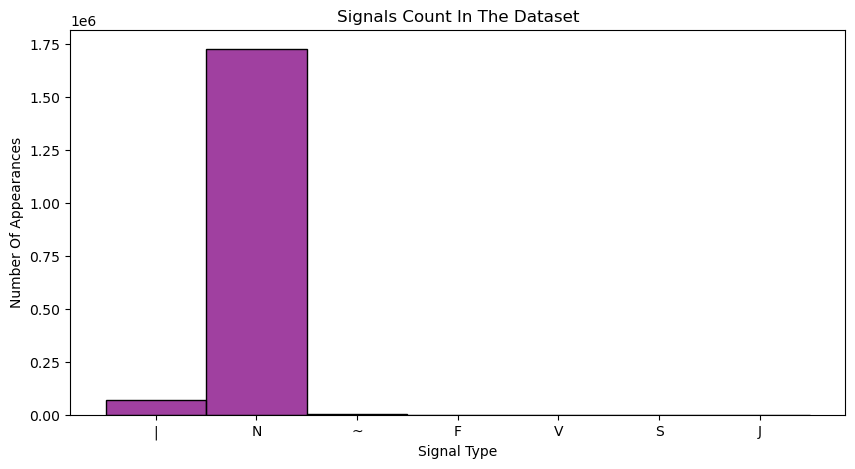

In [349]:
plt.figure(figsize=(10,5))
sns.histplot(np.array(symbols_tt), color="purple")
plt.title("Signals Count In The Dataset")
plt.xlabel("Signal Type")
plt.ylabel("Number Of Appearances")
plt.show()

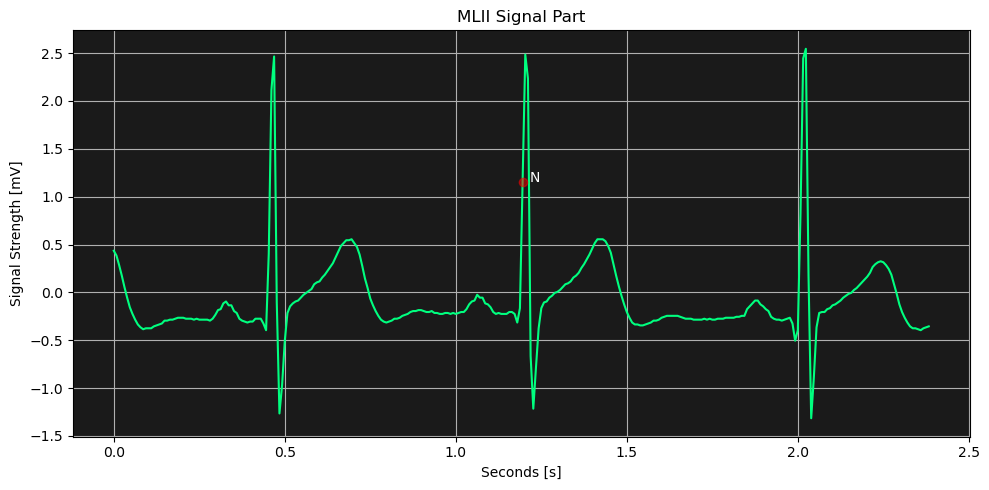

In [379]:
plot_signal(signals_tt[700000], int(seconds*128), symbols_tt[700000], fs=128)

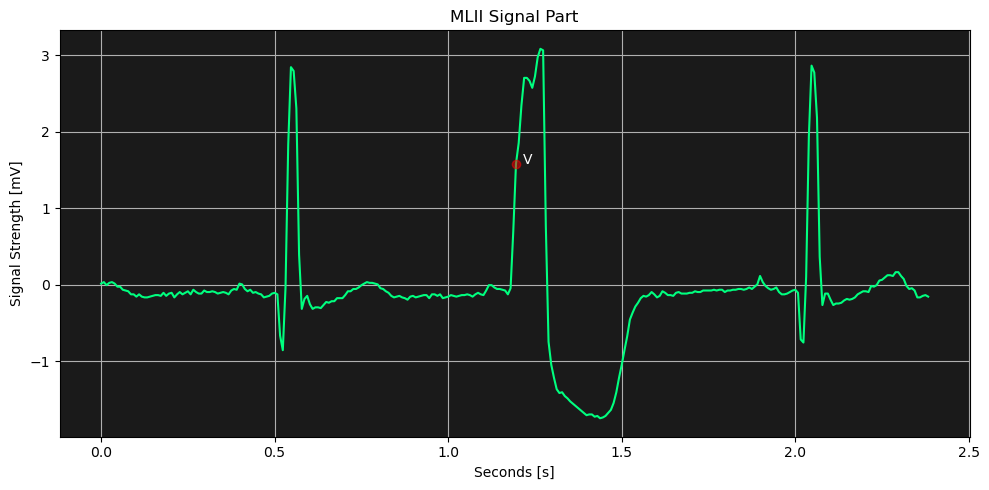

In [381]:
idx = symbols_tt.index("V")
plot_signal(signals_tt[idx], int(seconds*128), symbols_tt[idx], fs=128)

Text(0, 0.5, 'Amplituda')

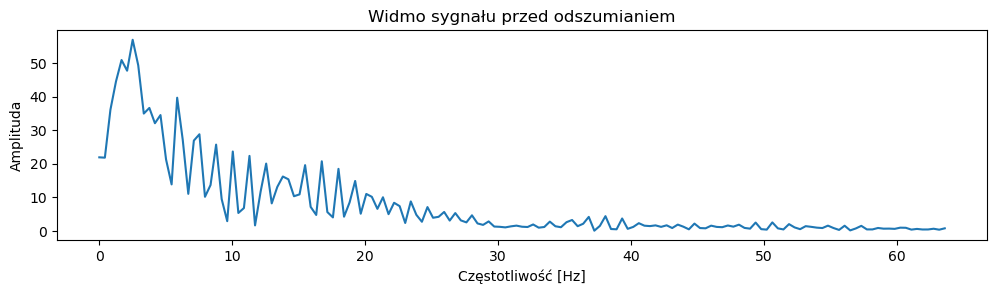

In [409]:
fs = 128
time_frame = 2 * seconds
t = np.linspace(0, time_frame, int(fs*time_frame))[:-1]


fft_signal = fft(signals_tt[idx])
frequencies = np.fft.fftfreq(len(fft_signal), 1/fs)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_signal)[:len(frequencies)//2])
plt.title('Widmo sygnału przed odszumianiem')
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Amplituda')

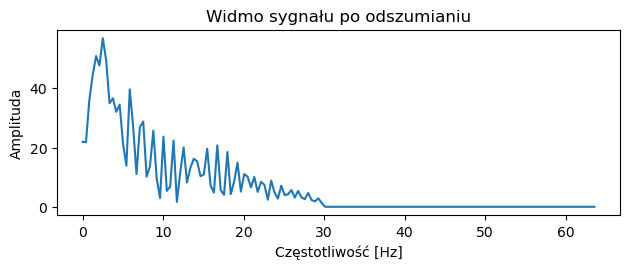

In [463]:
fft_signal_filtered = fft_signal.copy()
fft_signal_filtered[(frequencies > 30)] = 0

# Odtworzenie sygnału po filtracji
filtered_signal = ifft(fft_signal_filtered)

# Wyświetlenie widma sygnału po odszumianiu
plt.subplot(2, 1, 2)
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_signal_filtered)[:len(frequencies)//2])
plt.title('Widmo sygnału po odszumianiu')
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Amplituda')
plt.tight_layout()
plt.show()

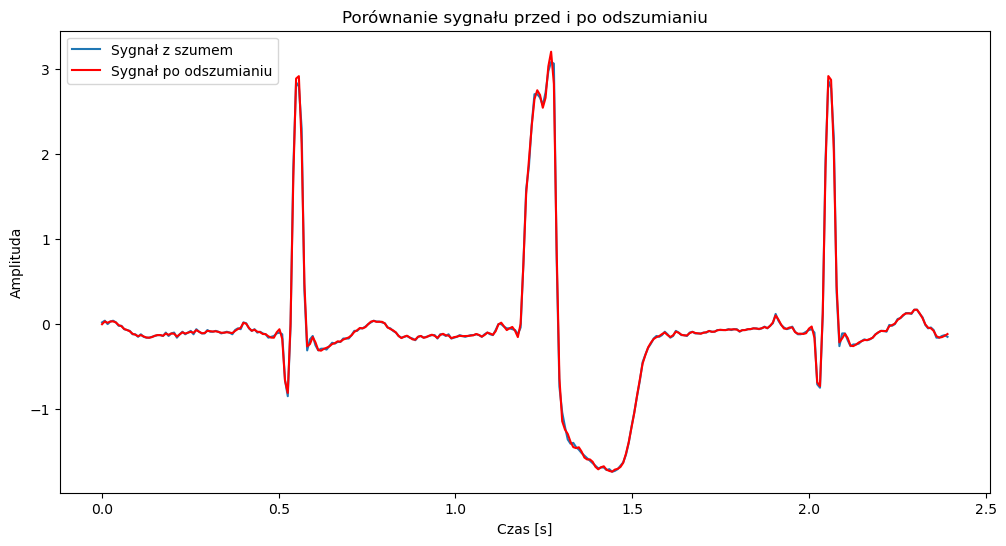

In [465]:
plt.figure(figsize=(12, 6))
plt.plot(t, signals_tt[idx], label='Sygnał z szumem')
plt.plot(t, filtered_signal.real, label='Sygnał po odszumianiu', color='red')
plt.legend()
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Porównanie sygnału przed i po odszumianiu')
plt.show()

In [405]:
len(t)

307

In [407]:
len(signals_tt[idx])

306